In [1]:
import csv 
import networkx as nx
import matplotlib.pyplot as plt
from graph import Graph
from article import Article
import random

In [2]:
graph = Graph()

**Part 1 : read the articles category file**
Populate the graph with articles, categories and categories 

In [3]:
graph.update_graph("data/categories.tsv", edges=False, verbose=True)

The graph has 5204 articles, 
15 categories, 
and 0 edges.


**Part 2 : Add the edges between the vertices**

In [4]:
graph.update_graph("data/paths_finished.tsv", edges=True, verbose=True) 

The graph has 5204 articles, 
15 categories, 
and 37553 edges.


In [5]:
graph.update_graph("data/paths_unfinished.tsv", edges=True, verbose=True)

The graph has 5204 articles, 
15 categories, 
and 44872 edges.


**get top 10 categories**

In [6]:
import pandas as pd

In [7]:
sizes = dict(sorted(graph.categories.items(), key=lambda item: item[1].size,reverse=True))


In [8]:
sizes = {k: v.size for k, v in sizes.items()}

**in Size**

In [33]:
sizes  = pd.DataFrame.from_dict(sizes,columns=['size'],orient='index').head(20)


**number of edges**

In [34]:
edges = dict(sorted(graph.categories.items(), key=lambda item: item[1].out_weight + item[1].in_weight,reverse=True))


In [35]:
edges = {k: v.out_weight + v.in_weight for k, v in edges.items()}

In [36]:
pd.DataFrame.from_dict(edges,columns=['edges'],orient='index').head(20)


,edges
Geography,22071
Science,12010
People,10090
History,9315
Everyday_life,6921
Countries,6570
Citizenship,6362
Language_and_literature,4204
Religion,3525
Design_and_Technology,2898


In [37]:
out_flow = dict(sorted(graph.categories.items(), key=lambda item: item[1].out_weight,reverse=True))
out_flow = {k: v.out_weight  for k, v in out_flow.items()}

out_topics = pd.DataFrame.from_dict(out_flow,columns=['out'],orient='index').head(20)


In [38]:
out_topics

,out
Geography,9040
Science,6688
People,6237
History,4652
Everyday_life,3855
Citizenship,3143
Countries,2786
Language_and_literature,1886
Design_and_Technology,1753
Religion,1684


In [39]:
in_flow = dict(sorted(graph.categories.items(), key=lambda item: item[1].in_weight,reverse=True))
in_flow = {k: v.in_weight  for k, v in in_flow.items()}

in_topics  = pd.DataFrame.from_dict(in_flow,columns=['in'],orient='index').head(20)

In [40]:
in_topics

,in
Geography,13031
Science,5322
History,4663
People,3853
Countries,3784
Citizenship,3219
Everyday_life,3066
Language_and_literature,2318
Religion,1841
Design_and_Technology,1145


In [41]:
topics = out_topics.join(in_topics)

In [43]:
df = topics.join(sizes)

In [57]:
df['total'] = df['out'] + df['in']
df['size/total'] = (df['size']/df['total'] * 100).map('{:,.2f}'.format)
df['out/total'] = (df['out']/df['total'] * 100).map('{:,.2f}'.format)
df['in/total'] = (df['in']/df['total'] * 100).map('{:,.2f}'.format)
df['out - in'] = df['out'] - df['in']
df['ratio_total_all'] = (df['total'] / sum(df['total']) * 100).map('{:,.2f}'.format)
df['ratio_size_all'] = (df['size'] / sum(df['size']) * 100).map('{:,.2f}'.format)
df['ratio_out_all'] = (df['out'] / sum(df['out']) * 100).map('{:,.2f}'.format)
df['ratio_in_all'] = (df['in'] / sum(df['in']) * 100).map('{:,.2f}'.format)
df = df.sort_values(by=['size'],ascending=False)
df

,out,in,size,total,size/total,out/total,in/total,out - in,ratio_total_all,size_total_all,ratio_size_all,ratio_out_all,ratio_in_all
Science,6688,5322,1122,12010,9.34,55.69,44.31,1366,13.38,21.56,21.56,14.90,11.86
Geography,9040,13031,1084,22071,4.91,40.96,59.04,-3991,24.59,20.83,20.83,20.15,29.04
People,6237,3853,689,10090,6.83,61.81,38.19,2384,11.24,13.24,13.24,13.90,8.59
History,4652,4663,545,9315,5.85,49.94,50.06,-11,10.38,10.47,10.47,10.37,10.39
Everyday_life,3855,3066,374,6921,5.40,55.70,44.30,789,7.71,7.19,7.19,8.59,6.83
Design_and_Technology,1753,1145,254,2898,8.76,60.49,39.51,608,3.23,4.88,4.88,3.91,2.55
Countries,2786,3784,229,6570,3.49,42.40,57.60,-998,7.32,4.40,4.40,6.21,8.43
Citizenship,3143,3219,224,6362,3.52,49.40,50.60,-76,7.09,4.30,4.30,7.00,7.17
Language_and_literature,1886,2318,196,4204,4.66,44.86,55.14,-432,4.68,3.77,3.77,4.20,5.17
Religion,1684,1841,134,3525,3.80,47.77,52.23,-157,3.93,2.57,2.57,3.75,4.10


In [52]:
df.describe()

,out,in,size,total,out - in
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,2991.466667,2991.466667,346.933333,5982.933333,0.000000
std,2630.348941,3231.607934,357.718258,5734.212569,1357.518692
min,434.000000,340.000000,38.000000,810.000000,-3991.000000
25%,828.500000,732.000000,92.500000,1484.500000,-116.500000
50%,1886.000000,2318.000000,224.000000,4204.000000,39.000000
75%,4253.500000,3818.500000,459.500000,8118.000000,457.000000
max,9040.000000,13031.000000,1122.000000,22071.000000,2384.000000


%C3%85land
%C3%89ire
1928_Okeechobee_Hurricane
1980_eruption_of_Mount_St._Helens
1997_Pacific_hurricane_season
2003_Atlantic_hurricane_season
2004_Atlantic_hurricane_season
2004_Indian_Ocean_earthquake
2005_Atlantic_hurricane_season
2005_Kashmir_earthquake
2005_Lake_Tanganyika_earthquake
2005_Sumatra_earthquake
Aachen
Aarhus
Abadan
Aberdeen
Aberystwyth
Abidjan
Abkhazia
Abu_Dhabi
Abuja
Accra
Acid_rain
Addis_Ababa
Adelaide
Afghanistan
Africa
African_Great_Lakes
Akrotiri_and_Dhekelia
Albania
Algeria
Algiers
Almaty
Amarillo%2C_Texas
Amazon_Basin
Amazon_Rainforest
Amazon_River
Amber
American_Samoa
Amish
Ammolite
Ammonite
Amsterdam
Amur
Andes
Andorra
Andriyivskyy_Descent
Angkor
Angola
Anguilla
Ann_Arbor%2C_Michigan
Antananarivo
Antarctic_Treaty_System
Antarctica
Anthropology
Antigua_and_Barbuda
Antwerp
Aral_Sea
Arctic
Arctic_Circle
Arctic_Ocean
Argentina
Argyle_diamond_mine
Armenia
Aruba
Asia
Asunci%C3%B3n
Ateneo_de_Manila_University
Athens
Atlanta%2C_Georgia
Atlantic_Ocean
Auckland
Australi

9040

In [60]:
graph.categories['Geography'].neighbors_in

{'History': 1779,
 'Citizenship': 1045,
 'Science': 2917,
 'People': 2279,
 'Everyday_life': 1312,
 'Religion': 423,
 'Countries': 1230,
 'Language_and_literature': 600,
 'Design_and_Technology': 645,
 'Business_Studies': 297,
 'Music': 284,
 'Mathematics': 25,
 'Art': 88,
 'IT': 107}

In [15]:
def color_list(n):
    colors = []
    for i in range(n):
        hexadecimal = ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])]
        colors.append(hexadecimal[0])
    #color_inc = 256*256*256/n
    #color_list = [x * color_inc for x in [*range(0,n)]]
    #color_list_str = [hex(int(x)) for x in color_list]
    #color_list = ["#" + zero_pad(x[2:]) for x in color_list_str]
    return colors

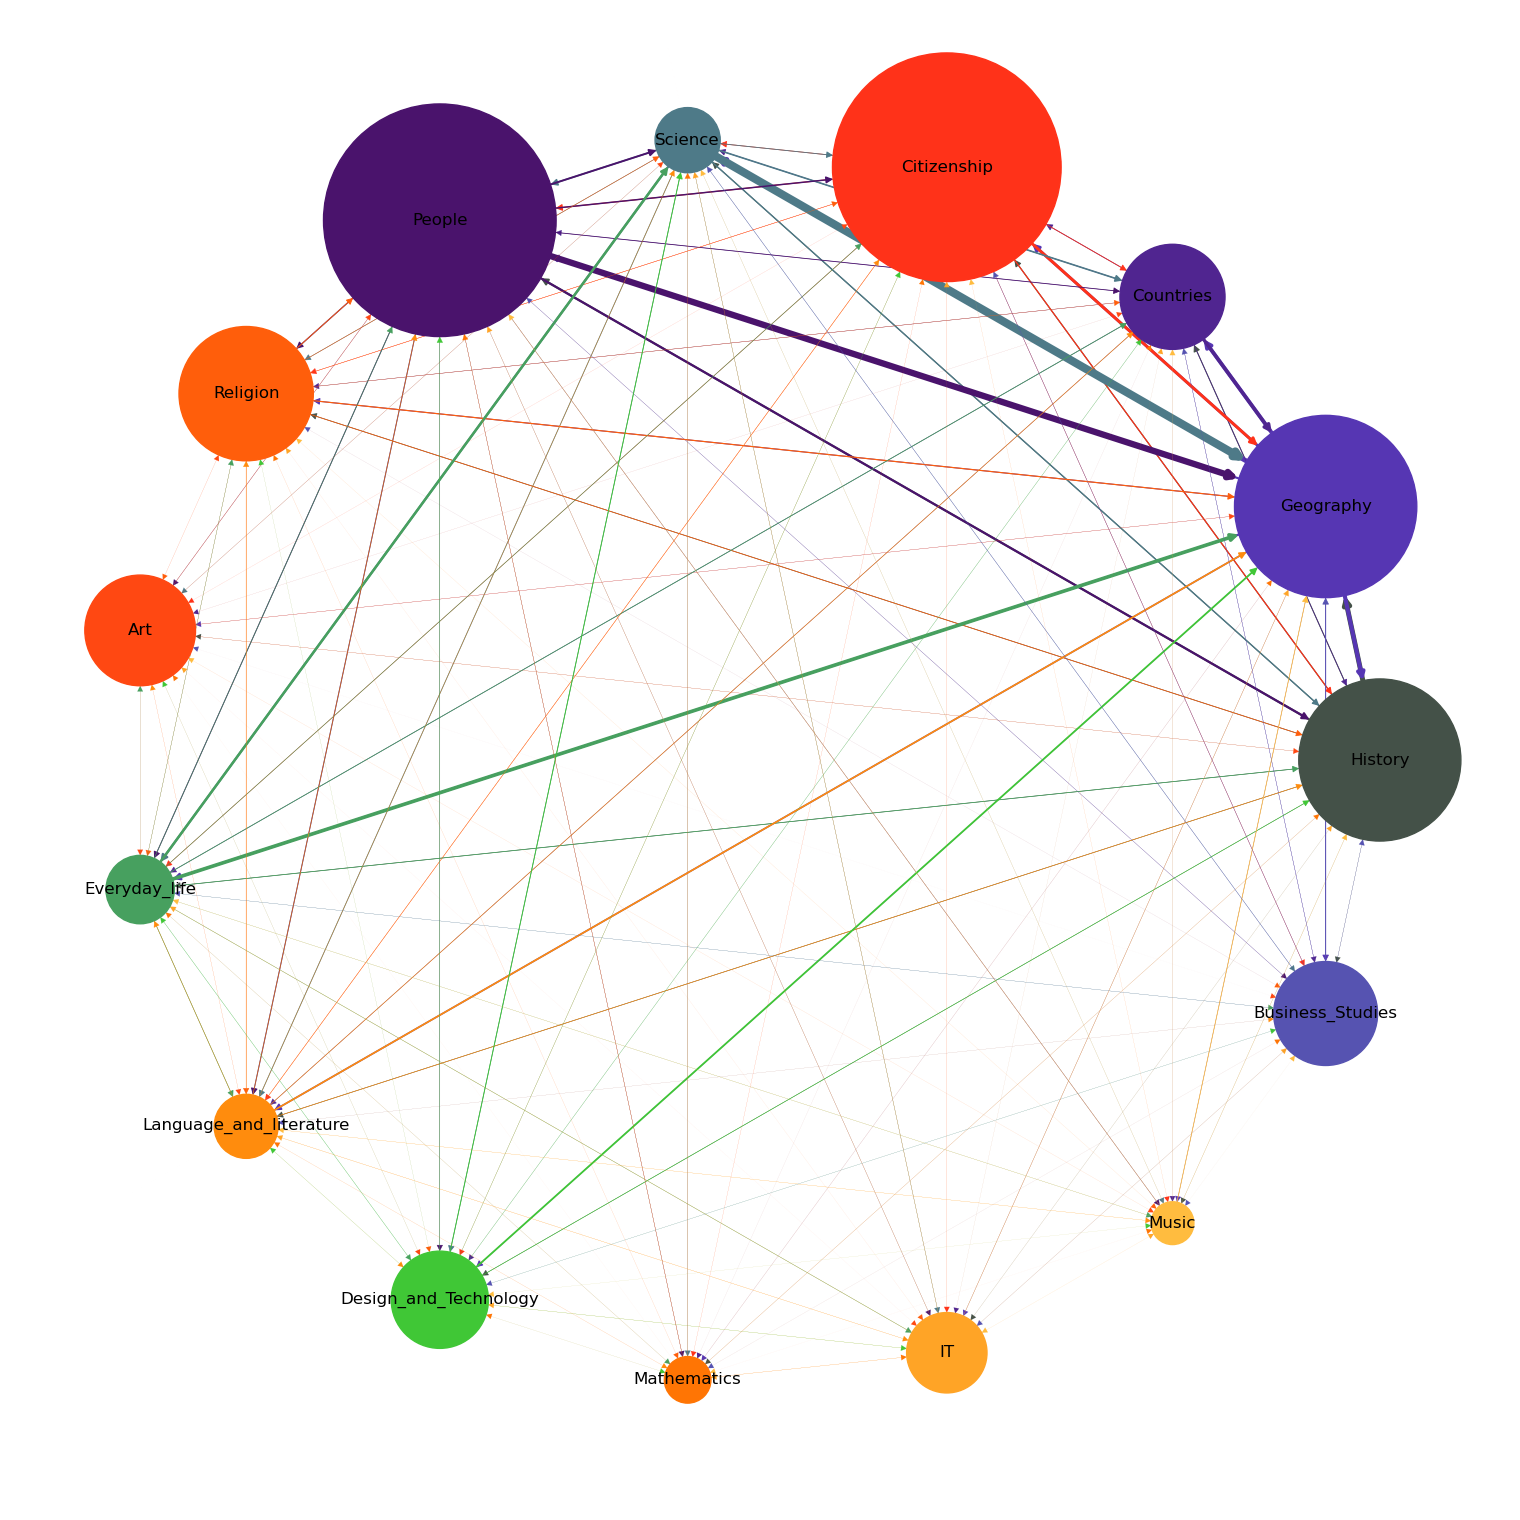

In [16]:
#nx.draw_random(G1,node_color = colors,labels = labels,with_labels = True) 
n = graph.nb_categories
#color = color_list(n)
color =['#445148', '#4a136c', '#502590', '#5636b3', '#5653b1',
        '#4e7a88', '#47a05f', '#40c736', '#ffbc3f', '#ffa426',
        '#ff8c0d', '#ff7504', '#ff5e0b', '#ff4812', '#ff3219']

labels = list(graph.categories.keys())
# map each category to a color
color_map = {category: color[i] for i, category in enumerate(graph.categories.keys())}

G1 = nx.DiGraph()
size = [t.size*25 for t in list(graph.categories.values())]
#loop on graph.matrixt
for key, value in graph.matrix.items():
    for key2, value2 in value.items():
            G1.add_edge(key,key2,weight=value2, color=color_map[key])


color = []
for node in G1.nodes(): 
    color.append(color_map[node])


label_dict = {}
for i in range(len(labels)):
    label_dict[labels[i]] = labels[i]
plt.figure(figsize=(15,15))

edges = G1.edges()
weights = [G1[u][v]['weight']/500 for u,v in edges]
colors = [G1[u][v]['color'] for u,v in edges]
nx.draw_circular(G1,node_size = size,node_color = color,labels=label_dict, width= weights, edge_color=colors)
plt.show()

In [17]:
nodePos = nx.circular_layout(G1)

In [18]:
nodePos

{'History': array([ 1.00000000e+00, -5.96046465e-09]),
 'Geography': array([0.91354543, 0.40673665]),
 'Countries': array([0.66913055, 0.74314489]),
 'Citizenship': array([0.30901695, 0.95105656]),
 'Science': array([-0.10452854,  0.99452194]),
 'People': array([-0.5000001 ,  0.86602541]),
 'Religion': array([-0.80901705,  0.58778525]),
 'Art': array([-0.97814768,  0.20791161]),
 'Everyday_life': array([-0.97814762, -0.2079118 ]),
 'Language_and_literature': array([-0.809017  , -0.58778533]),
 'Design_and_Technology': array([-0.49999995, -0.86602548]),
 'Mathematics': array([-0.10452836, -0.99452195]),
 'IT': array([ 0.3090171 , -0.95105651]),
 'Music': array([ 0.66913073, -0.74314472]),
 'Business_Studies': array([ 0.91354555, -0.40673651])}

In [19]:
graph.matrix['Art']

{'Science': 54,
 'Everyday_life': 45,
 'Language_and_literature': 33,
 'Music': 15,
 'Design_and_Technology': 21,
 'Business_Studies': 2,
 'History': 65,
 'People': 85,
 'Religion': 34,
 'Citizenship': 13,
 'Geography': 88,
 'IT': 4,
 'Countries': 16}

{'History': '#445148', 'People': '#4a136c', 'Countries': '#502590', 'Geography': '#5636b3', 'Business_Studies': '#5653b1', 'Science': '#4e7a88', 'Everyday_life': '#47a05f', 'Design_and_Technology': '#40c736', 'Music': '#ffbc3f', 'IT': '#ffa426', 'Language_and_literature': '#ff8c0d', 'Mathematics': '#ff7504', 'Religion': '#ff5e0b', 'Art': '#ff4812', 'Citizenship': '#ff3219'}


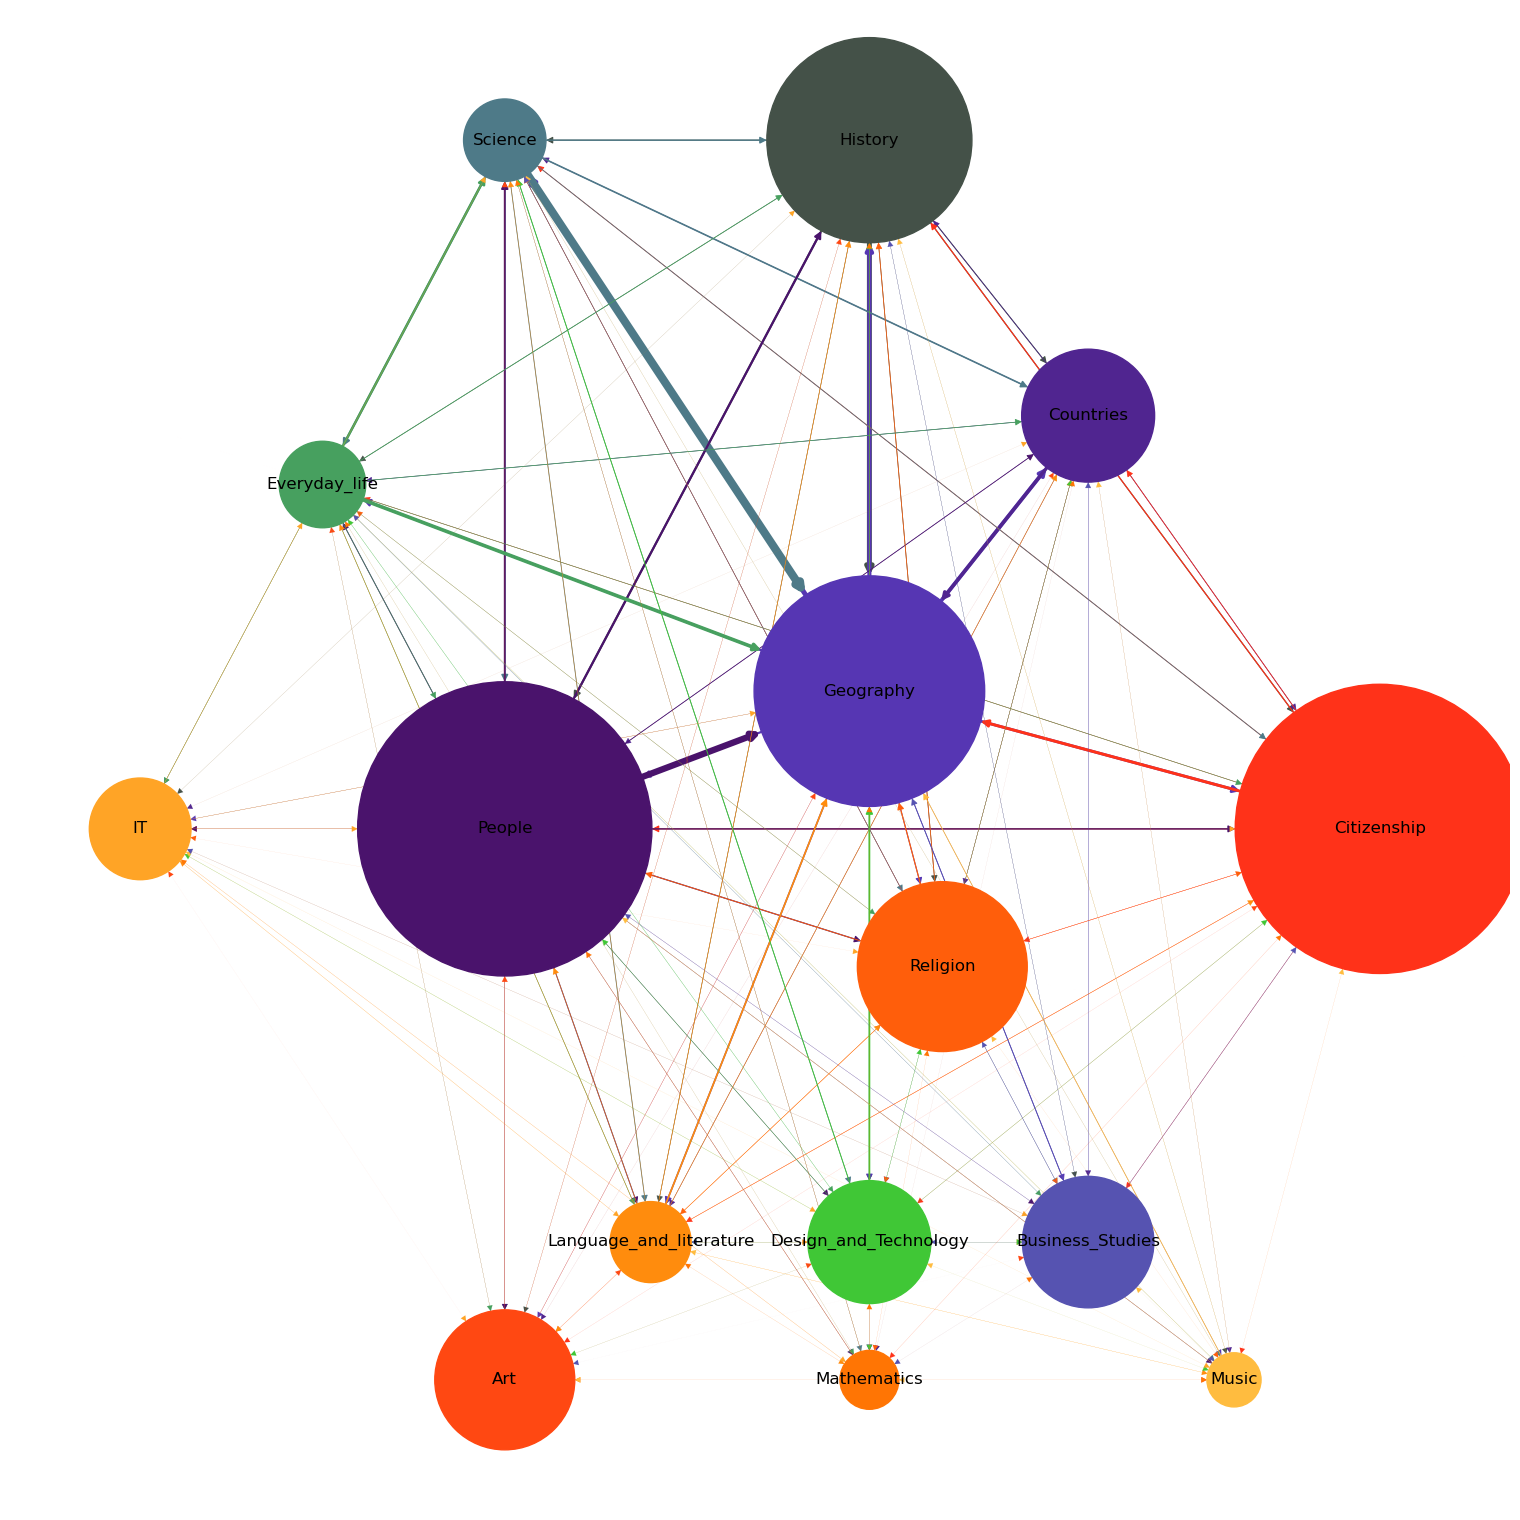

In [21]:
#design1


#nx.draw_random(G1,node_color = colors,labels = labels,with_labels = True) 
n = graph.nb_categories
#color = color_list(n)
color = ['#445148', '#4a136c', '#502590', '#5636b3', '#5653b1',
        '#4e7a88', '#47a05f', '#40c736', '#ffbc3f', '#ffa426',
        '#ff8c0d', '#ff7504', '#ff5e0b', '#ff4812', '#ff3219']
#'#440148
labels = list(graph.categories.keys())
# map each category to a color
color_map = {category: color[i] for i, category in enumerate(graph.categories.keys())}
print(color_map)
G1 = nx.DiGraph()
size = [t.size*40 for t in list(graph.categories.values())]
#loop on graph.matrixt
for key, value in graph.matrix.items():
    for key2, value2 in value.items():
     
            G1.add_edge(key,key2,weight=value2, color=color_map[key])
      


color = []
for node in G1.nodes(): 
    color.append(color_map[node])
  



label_dict = {}
for i in range(len(labels)):
    label_dict[labels[i]] = labels[i]
plt.figure(figsize=(15,15))

edges = G1.edges()
weights = [G1[u][v]['weight']/500 for u,v in edges]
colors = [G1[u][v]['color'] for u,v in edges]

nodePos = nx.circular_layout(G1)
nodePos['People'] = [ -0.5, 0]
nodePos['Citizenship'] = [0.7,0]
nodePos['Geography'] = [0,0.1]
nodePos['Science'] = [-0.5,0.5]
nodePos['Everyday_life'] = [-0.75,0.25]
nodePos['History'] = [0,0.5]
nodePos['Countries'] = [0.3,0.3]
nodePos['Design_and_Technology'] = [0,-0.3]
nodePos['Language_and_literature'] = [-0.3,-0.3]
nodePos['Religion'] = [0.1,-0.1]

nodePos['Mathematics'] = [0,-0.4]
nodePos['Art'] = [-0.5,-0.4]
nodePos['IT'] = [-1,0]

nodePos['Music'] = [0.5,-0.4]
nodePos['Business_Studies'] = [0.3,-0.3]

#people,science citizenship geograpgy  everydaylife
nx.draw(G1,node_size = size,pos = nodePos,node_color = color,labels=label_dict, width= weights, edge_color=colors)
plt.show()